# LSTM

In [1]:
#import packages
import numpy as np
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import random
import math
from datetime import datetime
import pickle
import pandas as pd
%matplotlib inline

#predefined activation function and its derivative
def Sigmoid(x): 
    return 1. / (1 + np.exp(-x))

def dSigmoid(values): 
    return values*(1-values)

def Tanh(x):
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def dtanh(values): 
    return 1. - values**2

def rand_arr(a, b, *args): 
    seed(0)
    return rand(*args)*(b - a) + a

#LSTM Class
class LSTM:
    def __init__(self, X_dim, y_dim, neuron):
        
        self.X_dim = X_dim 
        self.y_dim = y_dim
        self.neuron = neuron
        
        #initiate weight
        self.weight_f = rand_arr(-0.1, 0.1, neuron, X_dim + neuron)
        self.weight_i = rand_arr(-0.1, 0.1, neuron, X_dim + neuron)
        self.weight_g = rand_arr(-0.1, 0.1, neuron, X_dim + neuron) 
        self.weight_o = rand_arr(-0.1, 0.1, neuron, X_dim + neuron)
        self.weight_out = rand_arr(-0.1, 0.1, y_dim, neuron)
        
        #initiate bias
        self.bias_f = rand_arr(-0.1, 0.1, neuron) 
        self.bias_i = rand_arr(-0.1, 0.1, neuron) 
        self.bias_g = rand_arr(-0.1, 0.1, neuron) 
        self.bias_o = rand_arr(-0.1, 0.1, neuron)
        self.bias_out = rand_arr(-0.1, 0.1, y_dim)
    
    def forward(self, inputs, outputs):
        X = inputs
        y = outputs
        
        self.X = X
        self.y = y
        #make list to save the values of every unit 
        self.X_concat = []
        self.f = []
        self.i = []
        self.g = []
        self.o = []
        self.s = [zeros(self.neuron)] #first s input is 0
        self.h = [zeros(self.neuron)] #first h input is 0
        self.out = []
        self.error = []
        for i in range(len(inputs)):
            #forward for every unit
            X_concat = np.hstack((X[i],  self.h[i]))
            self.X_concat.append(X_concat)
            self.f.append(Sigmoid(self.weight_f@X_concat + self.bias_f))
            self.i.append(Sigmoid(self.weight_i@X_concat + self.bias_i))
            self.g.append(Tanh(self.weight_g@X_concat + self.bias_g))
            self.o.append(Sigmoid(self.weight_o@X_concat + self.bias_o))
            self.s.append(self.f[i]*self.s[i] + self.i[i]*self.g[i])
            self.h.append(Tanh(self.s[i+1])*self.o[i])
            self.out.append(self.weight_out@self.h[i+1] + self.bias_out)
            self.error.append(abs(self.out[-1] - y[i]))
        #show error
        #print(np.array(self.error).mean())
    
    def backward(self, inputs, outputs):
        self.diff_out = []
        self.diff_h = []
        self.diff_h_bottom = [zeros(self.neuron)]
        self.diff_s_up = [zeros(self.neuron)]
        self.diff_s = []
        self.diff_o = []
        self.diff_g = []
        self.diff_i = []
        self.diff_f = []
        for i in range(len(inputs)-1,-1,-1):
            #derivate of output
            if i == len(inputs)-1:
                self.diff_out  = [2*(self.out[i] - outputs[i])] + self.diff_out
                self.diff_h = [self.diff_out[0]*dSigmoid(self.weight_out@self.h[i+1] + self.bias_out)*self.weight_out + self.diff_h_bottom[0]] + self.diff_h
            else:
                self.diff_h = [self.diff_h_bottom[0]] + self.diff_h
            
            
            #derivative of gate/neural network operation
            self.diff_s = [self.diff_h[0]*self.o[i]*dtanh(self.s[i+1]) + self.diff_s_up[0]] + self.diff_s
            self.diff_o = [self.diff_h[0]*Tanh(self.s[i+1])] + self.diff_o
            self.diff_g = [self.i[i]*self.diff_s[0]] + self.diff_g
            self.diff_i = [self.g[i]*self.diff_s[0]] + self.diff_i
            self.diff_f = [self.s[i]*self.diff_s[0]] + self.diff_f
            
            #derivative of concatenation of input dan previous output value
            self.dX_concat = (self.diff_o[0].T*(dSigmoid(self.o[i]).reshape(self.neuron,1))).T@self.weight_o
            self.dX_concat += (self.diff_g[0].T*(dSigmoid(self.g[i]).reshape(self.neuron,1))).T@self.weight_g
            self.dX_concat += (self.diff_i[0].T*(dSigmoid(self.i[i]).reshape(self.neuron,1))).T@self.weight_i
            self.dX_concat += (self.diff_f[0].T*(dSigmoid(self.f[i]).reshape(self.neuron,1))).T@self.weight_f
            
            #update value of long and short term memory
            self.diff_h_bottom = [self.dX_concat[-1][self.X_dim:]] + self.diff_h_bottom
            self.diff_s_up = [self.diff_s[0]*self.f[i]] + self.diff_s_up
            
    def update(self, alpha):
        
        #alpha 
        
        #update everyweight and bias
        self.weight_out -= alpha*self.diff_out[0].reshape(1,1)@self.h[1].T.reshape(1,self.neuron)
        self.bias_out -= alpha*self.diff_out[0]
        
        self.weight_f -= alpha*(self.diff_f[0]*dSigmoid(self.weight_f@self.X_concat[0] + self.bias_f)).T@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_f -= alpha*(self.diff_f[0]*dSigmoid(self.weight_f@self.X_concat[0] + self.bias_f)).reshape(self.neuron,)
        
        self.weight_i -= alpha*(self.diff_i[0]*dSigmoid(self.weight_i@self.X_concat[0] + self.bias_i)).T@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_i -= alpha*(self.diff_i[0]*dSigmoid(self.weight_i@self.X_concat[0] + self.bias_i)).reshape(self.neuron,)
        
        self.weight_g -= alpha*(self.diff_g[0]*dSigmoid(self.weight_g@self.X_concat[0] + self.bias_g)).T@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_g -= alpha*(self.diff_g[0]*dSigmoid(self.weight_g@self.X_concat[0] + self.bias_g)).reshape(self.neuron,)
        
        self.weight_o -= alpha*(self.diff_o[0]*dSigmoid(self.weight_o@self.X_concat[0] + self.bias_o)).T.reshape(self.neuron,1)@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_o -= alpha*(self.diff_o[0]*dSigmoid(self.weight_o@self.X_concat[0] + self.bias_o)).reshape(self.neuron,)
    
    def predict(self, inputs, outputs):
        X = inputs
        y = outputs
        self.X = X
        self.y = y
        #make list to save the values of every unit 
        self.X_concat = []
        self.f = []
        self.i = []
        self.g = []
        self.o = []
        self.s = [zeros(self.neuron)] #first s input is 0
        self.h = [zeros(self.neuron)] #first h input is 0
        self.out = []
        self.error = []
        for i in range(len(inputs)):
            #forward for every unit
            X_concat = np.hstack((X[i],  self.h[i]))
            self.X_concat.append(X_concat)
            self.f.append(Sigmoid(self.weight_f@X_concat + self.bias_f))
            self.i.append(Sigmoid(self.weight_i@X_concat + self.bias_i))
            self.g.append(Tanh(self.weight_g@X_concat + self.bias_g))
            self.o.append(Sigmoid(self.weight_o@X_concat + self.bias_o))
            self.s.append(self.f[i]*self.s[i] + self.i[i]*self.g[i])
            self.h.append(Tanh(self.s[i+1])*self.o[i])
            self.out.append(self.weight_out@self.h[i+1] + self.bias_out)
            self.error.append(abs(self.out[-1] - y[i]))
        
        return [self.out[-1][0],self.y[-1]]
    
    def show_progress(self):
        return abs(self.y[-1][0] - self.out[-1])

# Change the Indicators Here!

In [2]:
#hyperparameters
epochs  = 1000
nc      = 10 #units

#datasets
name_dataset = 'PSDN-short'

column_dataset_obs = 'Close'

# Import Dataset

In [3]:
df = pd.read_csv('../../Datasets/'+name_dataset+'.csv')
df.drop('Volume', inplace=True, axis=1)
df

,Date,Open,High,Low,Close,Adj Close
0,2017-01-02,134.0,134.0,134.0,134.0,134.0
1,2017-01-03,135.0,139.0,135.0,139.0,139.0
2,2017-01-04,139.0,139.0,136.0,136.0,136.0
3,2017-01-05,135.0,141.0,135.0,141.0,141.0
4,2017-01-06,136.0,140.0,136.0,140.0,140.0
...,...,...,...,...,...,...
58,2017-03-23,170.0,170.0,162.0,162.0,162.0
59,2017-03-24,170.0,181.0,144.0,146.0,146.0
60,2017-03-27,146.0,151.0,146.0,146.0,146.0
61,2017-03-29,140.0,152.0,140.0,146.0,146.0


In [4]:
df.describe()

,Open,High,Low,Close,Adj Close
count,63.000000,63.000000,63.000000,63.000000,63.000000
mean,155.253968,158.412698,152.698413,155.365079,155.365079
std,12.317007,13.554710,12.055831,11.584614,11.584614
min,134.000000,134.000000,120.000000,134.000000,134.000000
25%,145.500000,148.000000,144.500000,146.000000,146.000000
50%,160.000000,161.000000,153.000000,160.000000,160.000000
75%,165.000000,168.000000,163.000000,164.500000,164.500000
max,182.000000,204.000000,171.000000,185.000000,185.000000


In [5]:
new_df = df.reset_index()[column_dataset_obs]
new_df

0     134.0
1     139.0
2     136.0
3     141.0
4     140.0
      ...  
58    162.0
59    146.0
60    146.0
61    146.0
62    147.0
Name: Close, Length: 63, dtype: float64

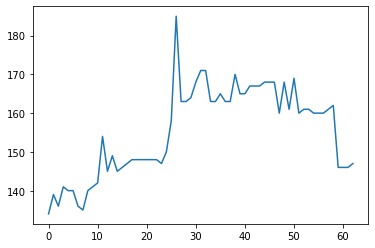

In [6]:
plt.plot(new_df)

# MinMax Scaler

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
new_df = scaler.fit_transform(np.array(new_df).reshape(-1,1))
# new_df

In [8]:
xs = new_df

In [9]:
#Standarized the dataset
N       = xs.shape[0]

#hypreparameter
Ts      = 1
x_dim   = 1
alpha   = 0.01 #learningrate

xt      = xs[0:N-x_dim,:]

for i in range(x_dim):
    xt  = hstack((xt, xs[i+1:N-x_dim+i+1]))   



# Splitting Training and Testing

In [10]:
training_size = int(len(new_df)*0.8)
test_size = len(new_df)-training_size

In [11]:
training_size, test_size

(50, 13)

In [12]:
X_train = xt[:training_size, 0:x_dim]     
y_train = xt[:training_size, x_dim:x_dim+1]  
X_test = xt[-test_size:, 0:x_dim]     
y_test = xt[-test_size:, x_dim:x_dim+1]

## Build LSTM Model

In [13]:
me = LSTM(x_dim,1,nc)
for i in range(epochs):
    print('-------------',i+1,'-------------')
    for j in range(X_train.shape[0]-Ts):
        me.forward(X_train[j:j+Ts],y_train[j:j+Ts])
        me.backward(X_train[j:j+Ts],y_train[j:j+Ts])
        me.update(alpha)
    hehe = []
    for j in range(X_test.shape[0]-Ts):
        me.forward(X_test[j:j+Ts],y_test[j:j+Ts])
        me.backward(X_test[j:j+Ts],y_test[j:j+Ts])
        me.update(alpha)
        hehe.append(me.show_progress())    
    print(np.array(hehe).mean())

------------- 1 -------------
0.1895498861932209
------------- 2 -------------
0.13111087311547379
------------- 3 -------------
0.11409376289302627
------------- 4 -------------
0.1091351681311999
------------- 5 -------------
0.10768695662115578
------------- 6 -------------
0.1072606601829193
------------- 7 -------------
0.1071318561931892
------------- 8 -------------
0.10708965674823083
------------- 9 -------------
0.10707266992281338
------------- 10 -------------
0.10706302381610905
------------- 11 -------------
0.1070555157140093
------------- 12 -------------
0.10704863105045953
------------- 13 -------------
0.10704192892233133
------------- 14 -------------
0.10703528098227992
------------- 15 -------------
0.10702864987156253
------------- 16 -------------
0.10702202471923945
------------- 17 -------------
0.10701540236523643
------------- 18 -------------
0.1070087818941561
------------- 19 -------------
0.10700216304400591
------------- 20 -------------
0.1069955457429

0.10598933582628767
------------- 176 -------------
0.10598295204897061
------------- 177 -------------
0.10597656903506124
------------- 178 -------------
0.10597018676404461
------------- 179 -------------
0.10596380521516151
------------- 180 -------------
0.10595742436740839
------------- 181 -------------
0.10595104419953665
------------- 182 -------------
0.10594466469005193
------------- 183 -------------
0.10593828581721361
------------- 184 -------------
0.10593190755903414
------------- 185 -------------
0.10592552989327819
------------- 186 -------------
0.10591915279746249
------------- 187 -------------
0.10591277624885505
------------- 188 -------------
0.10590640022447444
------------- 189 -------------
0.1059000247010891
------------- 190 -------------
0.10589364965521741
------------- 191 -------------
0.10588727506312597
------------- 192 -------------
0.10588090090083013
------------- 193 -------------
0.10587452714409284
------------- 194 -------------
0.10586815376

0.10490325118209072
------------- 344 -------------
0.10489650086086566
------------- 345 -------------
0.10488974400838748
------------- 346 -------------
0.10488298055536088
------------- 347 -------------
0.10487621043214473
------------- 348 -------------
0.1048694335687514
------------- 349 -------------
0.10486264989484623
------------- 350 -------------
0.10485585933974577
------------- 351 -------------
0.10484906183241773
------------- 352 -------------
0.10484225730147904
------------- 353 -------------
0.104835445675196
------------- 354 -------------
0.10482862688148233
------------- 355 -------------
0.10482180084789865
------------- 356 -------------
0.1048149675016516
------------- 357 -------------
0.10480812676959228
------------- 358 -------------
0.10480127857821586
------------- 359 -------------
0.10479442285366025
------------- 360 -------------
0.10478755952170508
------------- 361 -------------
0.10478068850777054
------------- 362 -------------
0.10477380973691

0.10367470243024003
------------- 505 -------------
0.10366573852250634
------------- 506 -------------
0.10365675155683295
------------- 507 -------------
0.10364774138866673
------------- 508 -------------
0.10363870787280101
------------- 509 -------------
0.10362965086337268
------------- 510 -------------
0.10362057021385863
------------- 511 -------------
0.10361146577707259
------------- 512 -------------
0.10360233740516193
------------- 513 -------------
0.10359318494960446
------------- 514 -------------
0.10358400826120436
------------- 515 -------------
0.10357480719008978
------------- 516 -------------
0.10356558158570865
------------- 517 -------------
0.10355633129682584
------------- 518 -------------
0.10354705617151912
------------- 519 -------------
0.10353775605717634
------------- 520 -------------
0.10352843080049147
------------- 521 -------------
0.10351908024746137
------------- 522 -------------
0.10350970424338217
------------- 523 -------------
0.1035003026

0.10166146433386702
------------- 676 -------------
0.10164578421916544
------------- 677 -------------
0.10163004340231575
------------- 678 -------------
0.10161424156146125
------------- 679 -------------
0.10159837837321502
------------- 680 -------------
0.10158245351265315
------------- 681 -------------
0.10156646665330815
------------- 682 -------------
0.10155041746716247
------------- 683 -------------
0.10153430562464151
------------- 684 -------------
0.10151813079460748
------------- 685 -------------
0.10150189264435201
------------- 686 -------------
0.10148559083959013
------------- 687 -------------
0.10146922504445322
------------- 688 -------------
0.10145279492148256
------------- 689 -------------
0.10143630013162264
------------- 690 -------------
0.10141974033421448
------------- 691 -------------
0.10140311518698886
------------- 692 -------------
0.10138642434606009
------------- 693 -------------
0.10136966746591854
------------- 694 -------------
0.1013528441

0.09793346692815312
------------- 842 -------------
0.09790197482538575
------------- 843 -------------
0.09787034352216846
------------- 844 -------------
0.09783857238189302
------------- 845 -------------
0.09780666076619515
------------- 846 -------------
0.09777460803496855
------------- 847 -------------
0.0977424135463784
------------- 848 -------------
0.09771007665687613
------------- 849 -------------
0.09767759672121307
------------- 850 -------------
0.09764497309245686
------------- 851 -------------
0.09761220512200552
------------- 852 -------------
0.09757929215960352
------------- 853 -------------
0.0975462335533586
------------- 854 -------------
0.09751302864975718
------------- 855 -------------
0.0974796767936819
------------- 856 -------------
0.09744617732842825
------------- 857 -------------
0.09741252959572282
------------- 858 -------------
0.09737873293574101
------------- 859 -------------
0.09734478668712528
------------- 860 -------------
0.0973106901870

In [14]:
import matplotlib.pyplot as plt

out = []
for j in range(X_test.shape[0]-Ts):
    out.append(me.predict(X_test[j:j+Ts],y_test[j:j+Ts]))

out=scaler.inverse_transform(out).tolist()

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## Report Performance of LSTM Predictions

In [15]:
from math import sqrt

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [16]:
# mse = mean_squared_error(y, predictions)
# print('MSE: '+str(mse))
print('epoch: ' + str(epochs))
print('units: ' + str(nc))

rmse = math.sqrt(mean_squared_error(np.array(out)[:,1], np.array(out)[:,0]))
print('RMSE: '+ str("{:.2f}".format(rmse)))
mae = mean_absolute_error(np.array(out)[:,1], np.array(out)[:,0])
print('MAE: '+ str("{:.2f}".format(mae)))
mape = mean_absolute_percentage_error(np.array(out)[:,1], np.array(out)[:,0])
print('MAPE: '+ str("{:.2f}".format(mape*100)))

epoch: 1000
units: 10
RMSE: 6.44
MAE: 4.89
MAPE: 3.18


## Visualize Test Data the Prediction and Real Stock

In [17]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

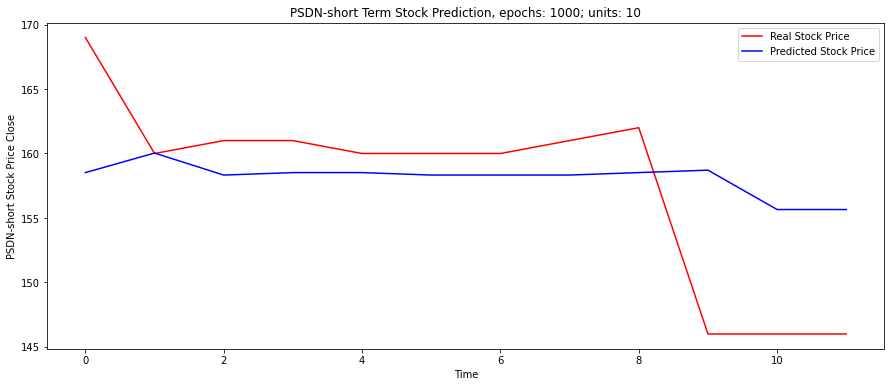

In [18]:
plt.figure()
plt.plot(np.array(out)[:,1], color = 'red', label = 'Real Stock Price')
plt.plot(np.array(out)[:,0], color = 'blue', label = 'Predicted Stock Price')
plt.title(name_dataset +' Term Stock Prediction, epochs: '+ str(epochs) +'; units: '+str(nc))
plt.xlabel('Time')
plt.ylabel(name_dataset +' Stock Price '+ column_dataset_obs)
plt.legend()

## Save as a new Dataset

In [19]:
real_price = np.array(out)[:,1]
close_lstm = np.array(out)[:,0]

In [20]:
new_data = {'real_price': real_price,
            'Close_LSTM': close_lstm}


In [21]:
df_new_data = pd.DataFrame(new_data, columns = ['real_price', 'Close_LSTM'])


In [22]:
df_new_data.to_csv('../../Datasets/dataset after prediction/'+name_dataset
                   +'_LSTM_'+ str(epochs) +'_'+ str(nc) + '.csv', index=False)